In [1]:
from utils.helper import traj_stat_analysis
from utils.helper import pca_analysis
from utils.helper import dtmc_abs_analysis
from utils.plot_func import plot_successRate,show_hist,plot_scatter
from utils.helper import fetchCriticalState,analyze_abstraction
import numpy as np


In [2]:
logdir = "Log/ppo1TFS-02262021-114243-victim/model/"

# 1. Load trajectories
* 加载profiling的轨迹数据，如使用相同策略进行游戏得到的selfplay数据。

In [3]:
filename = logdir+"best_model_selfplayer0_traj.data" 
orig_observations,all_actions,all_dones,all_rewards,all_hidden = traj_stat_analysis(filename)
print(all_hidden.shape)

(3999941, 13)
(3999941, 2)
(3999941,)
(3999941,)
(3999941, 8)
min obversations: [-1.04 -1.71 -1.01 -1.48 -1.04 -1.49 -1.01 -1.48 -0.91 -6.34 -1.03 -6.63
 -1.  ]
max obversations: [1.04 1.44 1.01 1.53 1.04 1.55 1.01 1.57 0.91 6.89 1.05 6.85 0.  ]
min actions: [-1. -1.]
max actions: [1. 1.]
(3999941, 8)


# 2. PCA Reduction on hidden features
* 对策略网络最后一隐层进行PCA降维（若隐层维度不高，可以跳过这一步）
* 此时concrete states就是PCA降维后的数据。

In [5]:
n_components = 6
pcaModelPath = logdir+"pcaModel_n{}.job".format(n_components)
pca_dic = pca_analysis(n_components,pcaModelPath,all_hidden,True)

build a PCA model...
>>>original:(3999941, 8)
>>>pca_data (3999941, 6)
>>>explained_variance_ratio 0.9740135442102658
PCA data min: [-2.3422 -2.4455 -1.6613 -1.5517 -1.7406 -1.4467]
PCA data max: [2.8465 2.6714 2.3903 1.8201 2.3729 1.7101]
>>>it takes 6.296159505844116 seconds.
Save the pca model to Log/ppo1TFS-02262021-114243-victim/model/pcaModel_n6.job successfully


In [5]:
# data = all_hidden
# for i in range(8):
#     mean,std = np.mean(data[:,i]), np.std(data[:,i])
#     unit = (np.max(data[i]) - np.min(data[i]))/8
#     show_hist(data[:,i],bin=100,range=None,title="dim:{},mean:{:.2f},std:{:.2f},unit:{:.2f}".format(i,mean,std,unit))

# 3. Model the agent as DTMC to capture its statistical behaviors

* 对PCA降维后的数据（即concrete states）进行DTMC抽象；
* 依据得分或者失分（reward=1|-1）进行trace划分；

In [6]:
grid_num = 8
abs_profiling_file = logdir+"profilingRes_g{}_n{}.dic".format(grid_num, n_components)
profiling_dic = dtmc_abs_analysis(pca_dic, all_rewards, grid_num,abs_profiling_file)


Total traces:22569
Success:11022
Failure:11547
Save profiling results to  Log/ppo1TFS-02262021-114243-victim/model/profilingRes_g8_n6.dic
The number of unique states:9589
The number of total states:262144
Coverage:0.04


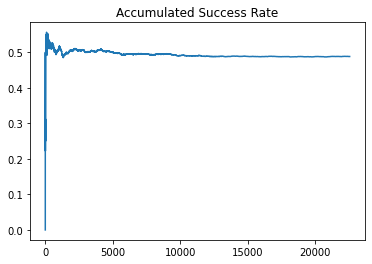

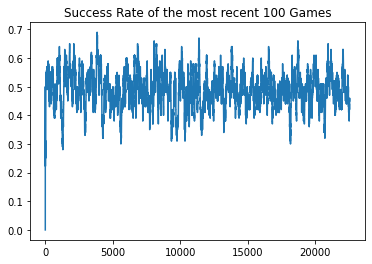

In [11]:

# plot_successRate(profiling_dic['results'],True,title="Accumulated Success Rate")
# plot_successRate(profiling_dic['results'],False, title="Success Rate of the most recent 100 Games")
# show_hist(np.array(profiling_dic['abs_states'],dtype=np.int32),bin=100,range=None,title="distribution of abstract states")

# 4. Analyze abstract states and traces

* 对抽象状态和抽象轨迹进行分析：
    * 获取每个抽象状态平均出现的频次avgFeq，可以此为标准过滤仅出现少量次数（不具有代表性）的抽象状态。
    * 建立抽象状态编号和原始concrete states下标的对应关系abs2con。
    * 记录经过状态s,失败的trace数量和胜利trace的数量 **state_dic;{'abs_state_id':\[fail_num, success_num\]}**。
    * 记录状态s的迁移关系，即状态转移图中每一条边，**transistion_dic：{'abs_state_id':\[next_state_id_list\]}**。
    * 根据state_dic,计算每一个抽象状态出现的频次，按照大小排序，用于获取过滤阈值，如percentile95。

In [7]:
avgFreq, abs2con, state_dic, transistion_dic = analyze_abstraction(profiling_dic['abs_states'],profiling_dic['abs_traces'])
occurance = []
for key,val in state_dic.items():
    occurance.append(val[0]+val[1])
occurance = np.array(sorted(occurance))
percent95 = int(np.percentile(occurance,95))
print("total covered states:",len(occurance))
print("when we choose avgFreq threshold (i.e.,{}) to filter rare states, only {} abstract states are kept.".format(
    int(avgFreq),len(np.where(occurance>avgFreq)[0])))
print("when we choose percent95 threshold (i.e.,{}) to filter rare states, only {} abstract states are kept.".format(
    percent95,len(np.where(occurance>percent95)[0])))

total covered states: 9589
when we choose avgFreq threshold (i.e.,417.13838773594745) to filter rare states, only 691 abstract states are kept.
when we choose percent95 threshold (i.e.,680) to filter rare states, only 480 abstract states are kept.


# 5. Fetch critical abstract states
* 获取关键抽象状态进行分析，得到critical状态列表:  \[ \[ **abs_state_id, fail_num, success_num, failRate** \] \], 好的抽象状态编号列表**good_list**和坏的抽象状态列表**bad_list**。
    * 对所有抽象状态根据threshold进行初步过滤
    * 根据failRate区分好状态和坏状态：failRate=(出现s失败的trace数量)/(所有出现s的trace数量)。failRate<threshold，好的状态；failRate>1-threshold，坏的状态。
  

In [8]:
critical, good_list, bad_list = fetchCriticalState(state_dic, percent95, threshold=0.35)

good state: 32
bad state: 7


# 6. Visualize abstract states
* 根据abs2con将抽象状态编号重新映射到具体状态，用一个抽象状态中虽有具体状态的平均值来表示当前抽象状态。
* 利用所有具体状态得到PCA模型，将维度压缩到3维以便可视化展示。
* 利用PCA模型绘制抽象状态在该空间上的位置

build a PCA model...
>>>original:(3999941, 8)
>>>pca_data (3999941, 3)
>>>explained_variance_ratio 0.8598952333524579
PCA data min: [-2.3422 -2.4455 -1.6613]
PCA data max: [2.8465 2.6714 2.3903]
>>>it takes 4.098388433456421 seconds.


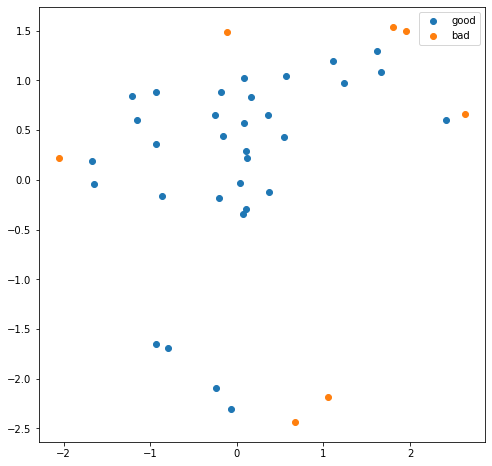

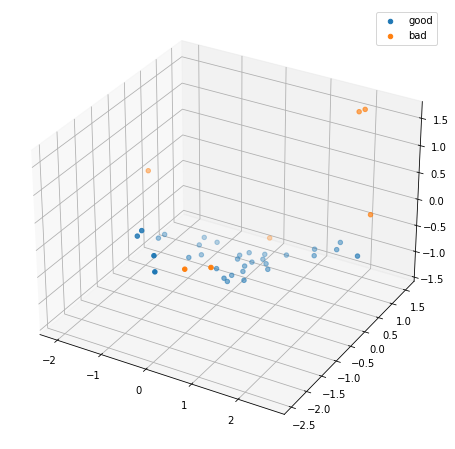

In [11]:
from utils.helper import get_abs_center
from abstraction.reduction import PCA_R
# 利用一个抽象状态中所有具体状态的平均值来表示当前抽象状态
good_abs_state = get_abs_center( all_hidden , abs2con, good_list)
bad_abs_state = get_abs_center( all_hidden , abs2con, bad_list)
# 利用原始所有的具体状态建立PCA模型
pcaModel = PCA_R(top_components=3)
pca_data, pca_min, pca_max = pcaModel.create_pca(all_hidden)
# 利用PCA模型绘制抽象状态在空间中的位置
plot_scatter(good_abs_state, bad_abs_state, pcaModel.pca, 2)
plot_scatter(good_abs_state, bad_abs_state, pcaModel.pca, 3)

# 7. Justify the division of abstract states
* 根据抽象状态编号和原始observation下标的对应关系，计算observation的v值。good/bad abstract states --> original observations --> value for good/bad observations。

In [12]:
import gym
import roboschool
from stable_baselines import PPO1
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
modelpath = logdir + "best_model.pkl"
env = gym.make("RoboschoolPong-v1")
seed = 101
env.seed(seed)
model = PPO1.load(modelpath,env=env)

In [13]:
bad_idx = []
for bad in bad_list:
    bad_idx.extend(abs2con[bad])
bad_idx = np.array(bad_idx)
print("bad observations:",bad_idx.shape[0])

good_idx = []
for good in good_list:
    good_idx.extend(abs2con[good])
good_idx = np.array(good_idx)
print("good observations:",good_idx.shape[0])

bad observations: 164845
good observations: 66958


In [14]:
bad_observation = orig_observations[bad_idx]
good_observation = orig_observations[good_idx]

bad_v = model.policy_pi.value(bad_observation)
good_v = model.policy_pi.value(good_observation)

In [15]:
import seaborn as sns
sns.set()
import matplotlib 
# matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
def plot_2_distribution(id_dis,id_label,ood_dis,ood_label,title="results",range = (0,1), kde=True):
    sns.set(color_codes=True)
    sns.distplot(id_dis,label = id_label,bins=40,kde=kde,hist_kws={'range':range,'edgecolor':"black",'alpha':0.5})
    sns.distplot(ood_dis,label = ood_label,bins=40,kde=kde,hist_kws={'range':range,'edgecolor':"black",'alpha':0.5})
    plt.legend()
    plt.title(title)
    plt.show() 

/home/lingjunz/anaconda3/envs/pong/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lingjunz/anaconda3/envs/pong/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


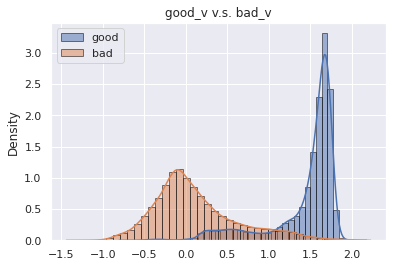

/home/lingjunz/anaconda3/envs/pong/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


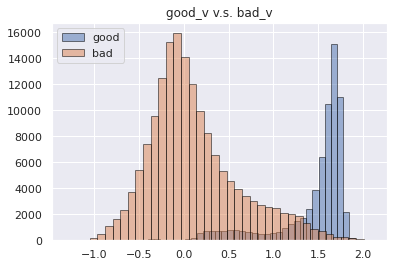

In [16]:
plot_2_distribution(good_v,'good',bad_v,'bad',title='good_v v.s. bad_v',range=None,kde=True)
plot_2_distribution(good_v,'good',bad_v,'bad',title='good_v v.s. bad_v',range=None,kde=False)

In [17]:
model.__dict__

{'policy': stable_baselines.common.policies.MlpPolicy,
 'env': <TimeLimit<RoboschoolPong<RoboschoolPong-v1>>>,
 'verbose': 1,
 '_requires_vec_env': False,
 'policy_kwargs': {'net_arch': [64, 64, {'pi': [8]}]},
 'observation_space': Box(13,),
 'action_space': Box(2,),
 'n_envs': 1,
 '_vectorize_action': False,
 'num_timesteps': 0,
 'graph': <tensorflow.python.framework.ops.Graph at 0x7fd05137dcf8>,
 'sess': <tensorflow.python.client.session.Session at 0x7fd05138b6a0>,
 'params': [<tf.Variable 'model/shared_fc0/w:0' shape=(13, 64) dtype=float32_ref>,
  <tf.Variable 'model/shared_fc0/b:0' shape=(64,) dtype=float32_ref>,
  <tf.Variable 'model/shared_fc1/w:0' shape=(64, 64) dtype=float32_ref>,
  <tf.Variable 'model/shared_fc1/b:0' shape=(64,) dtype=float32_ref>,
  <tf.Variable 'model/pi_fc0/w:0' shape=(64, 8) dtype=float32_ref>,
  <tf.Variable 'model/pi_fc0/b:0' shape=(8,) dtype=float32_ref>,
  <tf.Variable 'model/vf/w:0' shape=(64, 1) dtype=float32_ref>,
  <tf.Variable 'model/vf/b:0' shape